This tutorial illustrate a simple usage of Loter for local ancestry inference.

# Local Installation

For a global installation of Loter follow the procedure explain in the README.md at the top of the directory.
Here we demonstrate a simple way to directly use loter locally.
If you have already installed Loter, jump to [Loter usage](#loter_usage).

First, we need to compile the library

In [8]:
cd ..

/home/diasalvt/Loter/loter


In [5]:
!make

g++ -c -Wall -fPIC -O3 -msse2 -fopenmp src/init.cpp -o build/init.o
g++ -c -Wall -fPIC -O3 -msse2 -fopenmp src/haplophase.cpp -o build/haplophase.o
g++ -c -Wall -fPIC -O3 -msse2 -fopenmp src/estimatea/estimatea_c_api.cpp -o build/estimatea/estimatea_c_api.o
g++ -c -Wall -fPIC -O3 -msse2 -fopenmp src/estimatea/estimatea.cpp -o build/estimatea/estimatea.o
g++ -c -Wall -fPIC -O3 -msse2 -fopenmp src/datastruct/data.cpp -o build/datastruct/data.o
g++ -c -Wall -fPIC -O3 -msse2 -fopenmp src/datastruct/parameter_opti.cpp -o build/datastruct/parameter_opti.o
g++ -c -Wall -fPIC -O3 -msse2 -fopenmp src/datastruct/parameter_c_api.cpp -o build/datastruct/parameter_c_api.o
g++ -c -Wall -fPIC -O3 -msse2 -fopenmp src/datastruct/data_c_api.cpp -o build/datastruct/data_c_api.o
g++ -c -Wall -fPIC -O3 -msse2 -fopenmp src/graph/graph_c_api.cpp -o build/graph/graph_c_api.o
g++ -c -Wall -fPIC -O3 -msse2 -fopenmp src/graph/graph.cpp -o build/graph/graph.o
g++ -c -Wall -fPIC -O3 -msse2 -fopenmp src/parameter/m

If you do not have `OPENMP` installed on your computer, you'll need to desactivate this library.

In [9]:
!make no_omp=1

g++ -c -Wall -fPIC -O3 -msse2 -DDISABLE_OPENMP src/init.cpp -o build/init.o
g++ -c -Wall -fPIC -O3 -msse2 -DDISABLE_OPENMP src/haplophase.cpp -o build/haplophase.o
src/haplophase.cpp:198:0: attention : #pragma omp parallel ignoré [-Wunknown-pragmas]
   #pragma omp parallel for
 ^
src/haplophase.cpp:205:0: attention : #pragma omp critical ignoré [-Wunknown-pragmas]
     #pragma omp critical
 ^
src/haplophase.cpp:244:0: attention : #pragma omp parallel ignoré [-Wunknown-pragmas]
   #pragma omp parallel for
 ^
src/haplophase.cpp:251:0: attention : #pragma omp critical ignoré [-Wunknown-pragmas]
     #pragma omp critical
 ^
g++ -c -Wall -fPIC -O3 -msse2 -DDISABLE_OPENMP src/estimatea/estimatea_c_api.cpp -o build/estimatea/estimatea_c_api.o
g++ -c -Wall -fPIC -O3 -msse2 -DDISABLE_OPENMP src/estimatea/estimatea.cpp -o build/estimatea/estimatea.o
g++ -c -Wall -fPIC -O3 -msse2 -DDISABLE_OPENMP src/datastruct/data.cpp -o build/datastruct/data.o
g++ -c -Wall -fPIC -O3 -msse2 -DDISABLE_OPENMP src

In [10]:
cd python-package

/home/diasalvt/Loter/loter/python-package


Now we can directly use the Python package "loter" because we are in the good directory. If you installed `Loter` globally this is not necessary.

<a id='loter_usage'></a>
# Loter usage

To use Loter you will need some basic libraries as numpy, ctypes, pandas, scipy, sklearn...

## Load Data

In [61]:
import numpy as np

H_ceu = np.load("../data/H_ceu.npy")
H_yri = np.load("../data/H_yri.npy")

In [62]:
H_ceu.shape

(88, 50000)

In [63]:
H_yri.shape

(100, 50000)

## Create an admixed individual

In [64]:
H_met = np.copy(H_ceu[:2])

At the middle of the dataset, the ancestry switches between CEU and YRI.

In [65]:
pos_snp = H_yri.shape[1] / 2

In [66]:
print(pos_snp)

25000


In [67]:
H_met[:, pos_snp:] = H_yri[:2, pos_snp:]

## Run Loter

We exclude the 2 first individuals used to create the admixed individuals.

In [68]:
import loter.locanc.local_ancestry as lc

res_loter = lc.loter_smooth([H_ceu[2:], H_yri[2:]], H_met)

## Plot the result

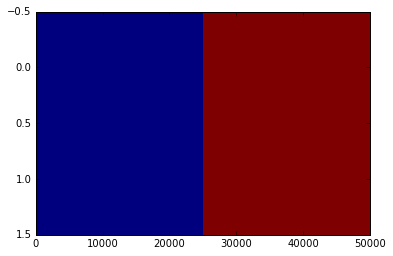

In [69]:
% matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(res_loter, interpolation='nearest', aspect='auto')

Where the switch appear in the result.

In [70]:
np.argwhere(np.diff(res_loter))

array([[    0, 24994],
       [    1, 24994]])

Notice you might find another result due to the stochastic nature of Loter.

# Loter with vcf

To load a VCF, we use [scikit allel](To load a VCF, we use scikit allel).

In [35]:
import allel

In [51]:
def vcf2npy(vcfpath):
    callset = allel.read_vcf(vcfpath)
    haplotypes_1 = callset['calldata/GT'][:,:,0]
    haplotypes_2 = callset['calldata/GT'][:,:,1]
    
    m, n = haplotypes_1.shape
    mat_haplo = np.empty((2*n, m))
    mat_haplo[::2] = haplotypes_1.T
    mat_haplo[1::2] = haplotypes_2.T
    
    return mat_haplo.astype(np.uint8)

These 3 files are the results of Beagle.

In [76]:
ceu_hap = vcf2npy('../data/ceu.vcf')
yri_hap = vcf2npy('../data/yri.vcf')
mex_hap = vcf2npy('../data/mex.vcf')

In [77]:
import loter.locanc.local_ancestry as lc

mex_admixed = lc.loter_smooth([ceu_hap, yri_hap], mex_hap)

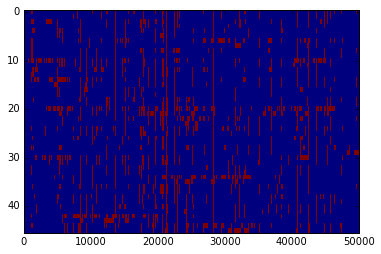

In [78]:
% matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(mex_admixed, interpolation='nearest', aspect='auto')